Here's a complete solution for your final term project using a classification dataset from Kaggle. I will assume that you are using Google Colab and Google Drive for your file storage and data access. This solution will cover implementing two models: Random Forest and LSTM, along with k-fold cross-validation and performance evaluation.

#Step 1: Set Up Google Colab with Google Drive
First, we'll mount Google Drive to access the dataset stored there.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Step 2: Import Libraries
Let's import all the necessary libraries for data analysis, model building, and evaluation.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


#Step 3: Load and Preprocess the Dataset
For this example, I will use the Heart Failure Prediction dataset from Kaggle.

In [4]:
# Load the dataset from Google Drive
data_path = '/content/drive/MyDrive/heart_csv/heart.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(data.head())

# Checking for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
print("\nCategorical columns:", categorical_columns)

# Convert categorical columns to numerical using One-Hot Encoding
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Splitting features (X) and target (y)
X = data.drop(columns='HeartDisease')
y = data['HeartDisease']

# Standardizing the features (important for LSTM)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Confirm the transformed data
print("\nTransformed feature matrix shape:", X_scaled.shape)
print("Transformed feature matrix sample:\n", X_scaled[:5])


First few rows of the dataset:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Missing values in each column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxH

#Step 4: Implementing k-Fold Cross-Validation
We'll set up k-fold cross-validation with 5 splits.

In [5]:
# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)


#Step 5: Model 1 - Random Forest Classifier
We'll implement a Random Forest classifier and evaluate it using k-fold cross-validation.

In [6]:
metrics_rf = []

for train_index, test_index in kf.split(X_scaled):
    # Splitting data into training and testing sets
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Store metrics
    metrics_rf.append([accuracy, precision, recall, f1, roc_auc])

# Convert to DataFrame for easy viewing
metrics_rf_df = pd.DataFrame(metrics_rf, columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'])
print("Random Forest Performance:\n", metrics_rf_df.mean())


Random Forest Performance:
 Accuracy     0.870331
Precision    0.867210
Recall       0.905575
F1-Score     0.885091
ROC AUC      0.929521
dtype: float64


#Step 6: Model 2 - LSTM for Sequence Classification
Next, we'll reshape the data for LSTM and evaluate it using k-fold cross-validation.

In [7]:
# Reshape the data for LSTM (samples, timesteps, features)
X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

metrics_lstm = []

for train_index, test_index in kf.split(X_lstm):
    # Splitting data into training and testing sets
    X_train, X_test = X_lstm[train_index], X_lstm[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Build LSTM Model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    lstm_model.add(Dense(1, activation='sigmoid'))

    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

    # Make predictions
    y_pred_proba = lstm_model.predict(X_test).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Store metrics
    metrics_lstm.append([accuracy, precision, recall, f1, roc_auc])

# Convert to DataFrame for easy viewing
metrics_lstm_df = pd.DataFrame(metrics_lstm, columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'])
print("LSTM Performance:\n", metrics_lstm_df.mean())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
LSTM Performance:
 Accuracy     0.870325
Precision    0.869805
Recall       0.903769
F1-Score     0.884920
ROC AUC      0.935169
dtype: float64


#Step 7: Visualize the Performance Metrics
Let's visualize the performance metrics for both models using bar plots.

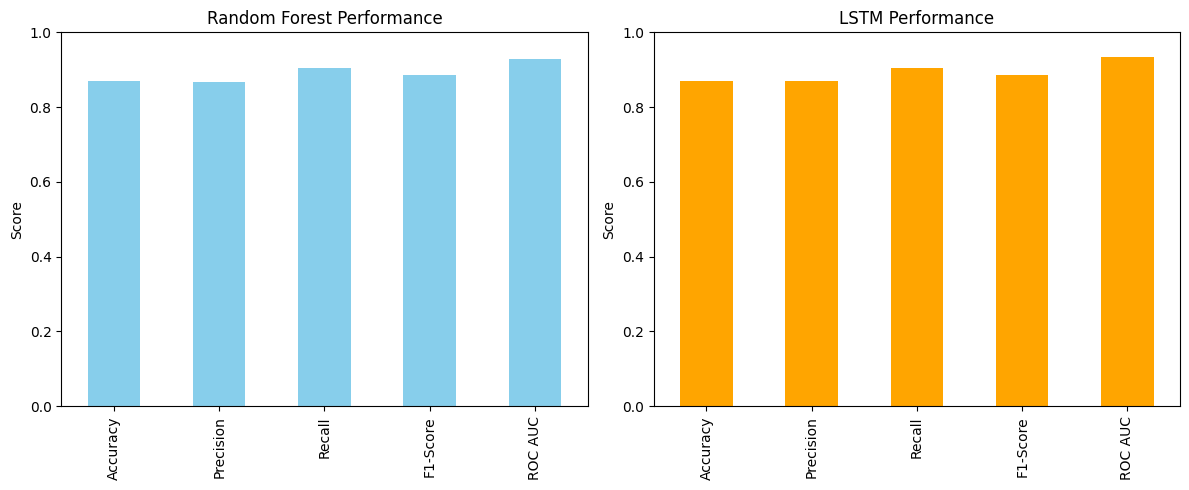

In [8]:
# Visualizing the metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest Metrics
metrics_rf_df.mean().plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title("Random Forest Performance")
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('Score')

# LSTM Metrics
metrics_lstm_df.mean().plot(kind='bar', ax=ax[1], color='orange')
ax[1].set_title("LSTM Performance")
ax[1].set_ylim(0, 1)
ax[1].set_ylabel('Score')

plt.tight_layout()
plt.show()


#Step 8: Confusion Matrix and ROC Curve

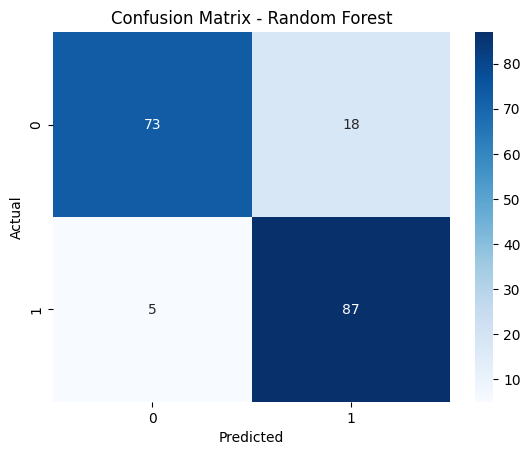

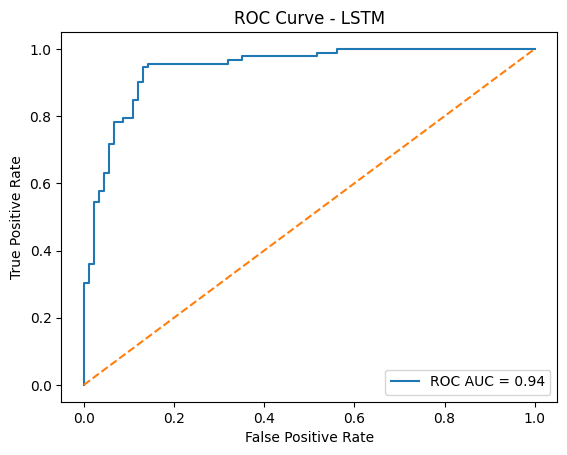

In [10]:
# If X_test was reshaped for LSTM, reshape it back to 2D for RandomForest
if len(X_test.shape) == 3:
    X_test_rf = X_test.reshape(X_test.shape[0], -1)  # Convert to 2D
else:
    X_test_rf = X_test

# Confusion Matrix for Random Forest
rf_y_pred = rf_model.predict(X_test_rf)
sns.heatmap(confusion_matrix(y_test, rf_y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve for LSTM
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve - LSTM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
